In [1]:
!pip install -q -U segmentation-models-pytorch > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


CONFIG = {
    "DATA_DIR": "/kaggle/input/deepglobe-road-extraction-dataset",
    "IMG_SIZE": 512, # resizing to 512 for memory efficiency
    "BATCH_SIZE": 8,
    "LEARNING_RATE": 1e-4,
    "EPOCHS": 10,
    "NUM_POINTS": 50,
    "IGNORE_INDEX": 255,
    "DEVICE": "cuda" if torch.cuda.is_available else "cpu"
}

print(f"Using Device: {CONFIG['DEVICE']}")

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using Device: cuda


In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
def simulate_points(mask, num_points = 50, ignore_index = 255):

    h, w = mask.shape
    flattened = mask.flatten()

    # sample points from both classes if possible

    road_indices = np.where(flattened == 1)[0]
    bg_indices = np.where(flattened == 0)[0]

    sparse_flattened = np.full_like(flattened, ignore_index)

    # 50/50 split
    if len(road_indices) > 0 and len(bg_indices) > 0:

        n_road = num_points // 2
        n_bg = num_points - n_road

        sampled_road = np.random.choice(road_indices, size = min(n_road, len(road_indices)), replace = False)
        sampled_bg = np.random.choice(bg_indices, size = min(n_bg, len(bg_indices)), replace= False)

        sparse_flattened[sampled_road] = 1
        sparse_flattened[sampled_bg] = 0

    else:

        indices = np.where(flattened != ignore_index)[0]

        if len(indices) > 0:

            sampled = np.random.choice(indices, size = min(num_points, len(indices)), replace = False)
            sparse_flattened[sampled] = flattened[sampled]

    return sparse_flattened.reshape(h, w)

In [5]:
class DeepGlobeRoadDataset(Dataset):
    def __init__(self, root_dir, split = "train", transform = None, points_per_image = 50):

        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.points_per_image = points_per_image

        #load data
        self.image_dir = os.path.join(root_dir, split)
        self.image_filenames = [f for f in os.listdir(self.image_dir) if f.endswith("_sat.jpg")]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        mask_name = img_name.replace('_sat.jpg', '_mask.png')
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.image_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

        _, mask = cv2.threshold(mask, 128, 1, cv2.THRESH_BINARY)


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask_np = mask.numpy()
        sparse_mask_np = simulate_points(mask_np, num_points=self.points_per_image, ignore_index=CONFIG['IGNORE_INDEX'])
        sparse_mask = torch.from_numpy(sparse_mask_np).long()
        mask = mask.long()
        
        return image, mask, sparse_mask


#  augmentation
train_transform = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# data loadr
train_dataset = DeepGlobeRoadDataset(CONFIG['DATA_DIR'], split='train', transform=train_transform, points_per_image=CONFIG['NUM_POINTS'])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [6]:
class PartialFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, ignore_index=255, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, inputs, targets):

        #  Standard CE
        ce_loss = F.cross_entropy(inputs, targets, ignore_index=self.ignore_index, reduction='none')

        # probabilities (pt
        pt = torch.exp(-ce_loss)

        # focal component
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        # partial Logic
        valid_mask = (targets != self.ignore_index).float()
        
        # apply teh mask to loss
        masked_focal_loss = focal_loss * valid_mask

        # normalize by >>LABELED<< pixels only
        if self.reduction == 'mean':
            return masked_focal_loss.sum() / (valid_mask.sum() + 1e-6)
        else:
            return masked_focal_loss.sum()

In [7]:
def calculate_iou(pred_mask, true_mask):
    """
        pred_mask: Tensor of shape (B, H, W) with 0/1 values
        true_mask: Tensor of shape (B, H, W) with 0/1 values
    Returns:
    float: IoU score
    """
    pred = pred_mask.view(-1)
    true = true_mask.view(-1)
    
    #  Intersection and Union
    intersection = (pred * true).sum()
    total = (pred + true).sum()
    union = total - intersection
    
    if union == 0:
        return 1.0
    
    return intersection.float() / union.float()

In [8]:

def run_exp(gamma, num_points, experiment_name):
    print(f"\n{'#'*10} Starting Experiment: {experiment_name} {'#'*10}")
    print(f"Parameters: Gamma={gamma}, Points={num_points}")
    
    train_ds = DeepGlobeRoadDataset(
        CONFIG['DATA_DIR'], 
        split='train', 
        transform=train_transform, 
        points_per_image=num_points
    )
    
    train_sz = int(0.8 * len(train_ds))
    val_sz = len(train_ds) - train_sz
    
    train_subset, _ = torch.utils.data.random_split(train_ds, [train_sz, val_sz])
    train_ldr = DataLoader(train_subset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)

    # model
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=2,
        activation=None
    ).to(CONFIG['DEVICE'])

    # loss & Optimizer
    criterion = PartialFocalLoss(alpha=1, gamma=gamma, ignore_index=CONFIG['IGNORE_INDEX'])
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])
    
    #training loop
    best_iou = 0.0
    
    for epoch in range(CONFIG['EPOCHS']):
        model.train()
        train_loss = 0
        
        for images, _, sparse_masks in train_ldr:
            images = images.to(CONFIG['DEVICE'])
            sparse_masks = sparse_masks.to(CONFIG['DEVICE'])
            
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, sparse_masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # validation
        model.eval()
        val_iou_sum = 0
        total_batches = 0
        
        with torch.no_grad():
            for images, full_masks, _ in val_loader:
                images = images.to(CONFIG['DEVICE'])
                full_masks = full_masks.to(CONFIG['DEVICE'])
                
                logits = model(images)
                preds = torch.argmax(logits, dim=1)
                
                # calculate IoU for this batch
                batch_iou = calculate_iou(preds, full_masks)
                val_iou_sum += batch_iou.item()
                total_batches += 1
        
        avg_val_iou = val_iou_sum / total_batches
        
        if (epoch+1) % 2 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | Loss: {train_loss/len(train_ldr):.4f} | Val IoU: {avg_val_iou:.4f}")
            
        if avg_val_iou > best_iou:
            best_iou = avg_val_iou

    #  save Model
    save_path = f"{experiment_name}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"-> Model saved to {save_path} | Best IoU: {best_iou:.4f}")
    
    
    return best_iou


In [9]:
"""
full_dataset = DeepGlobeRoadDataset(CONFIG['DATA_DIR'], split='train', transform=val_transform)
tr_size = int(0.8 * len(full_dataset))
v_size = len(full_dataset) - tr_size
_, val_subset = torch.utils.data.random_split(full_dataset, [tr_size, v_size])
val_loader = DataLoader(val_subset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)

# define xxperiments
experiments = [
    # Gamma Experiments (Fixed Points=50)
    {"gamma": 0, "points": 50, "name": "exp_gamma0_pts50"},
    {"gamma": 2, "points": 50, "name": "exp_gamma2_pts50"}, # baseline
    {"gamma": 3, "points": 50, "name": "exp_gamma3_pts50"},
    
    # Points Experiments (Fixed Gamma=2)
    {"gamma": 2, "points": 10,  "name": "exp_gamma2_pts10"},
    {"gamma": 2, "points": 30,  "name": "exp_gamma2_pts30"},
    {"gamma": 2, "points": 100, "name": "exp_gamma2_pts100"},
    {"gamma": 2, "points": 200, "name": "exp_gamma2_pts200"},
]

results = {}

for exp in experiments:
    score = run_exp(exp["gamma"], exp["points"], exp["name"])
    results[exp["name"]] = score

print("\n experiments Completed")
print(results)

"""
last_results_saved = {'exp_gamma0_pts50': 0.3358208982226176,
                      'exp_gamma2_pts50': 0.35221165485489064,
                      'exp_gamma3_pts50': 0.3381173616418472,
                      'exp_gamma2_pts10': 0.311444173925198,
                      'exp_gamma2_pts30': 0.32706103693598354,
                      'exp_gamma2_pts100': 0.39510359252110505,
                      'exp_gamma2_pts200': 0.35715849573413533}

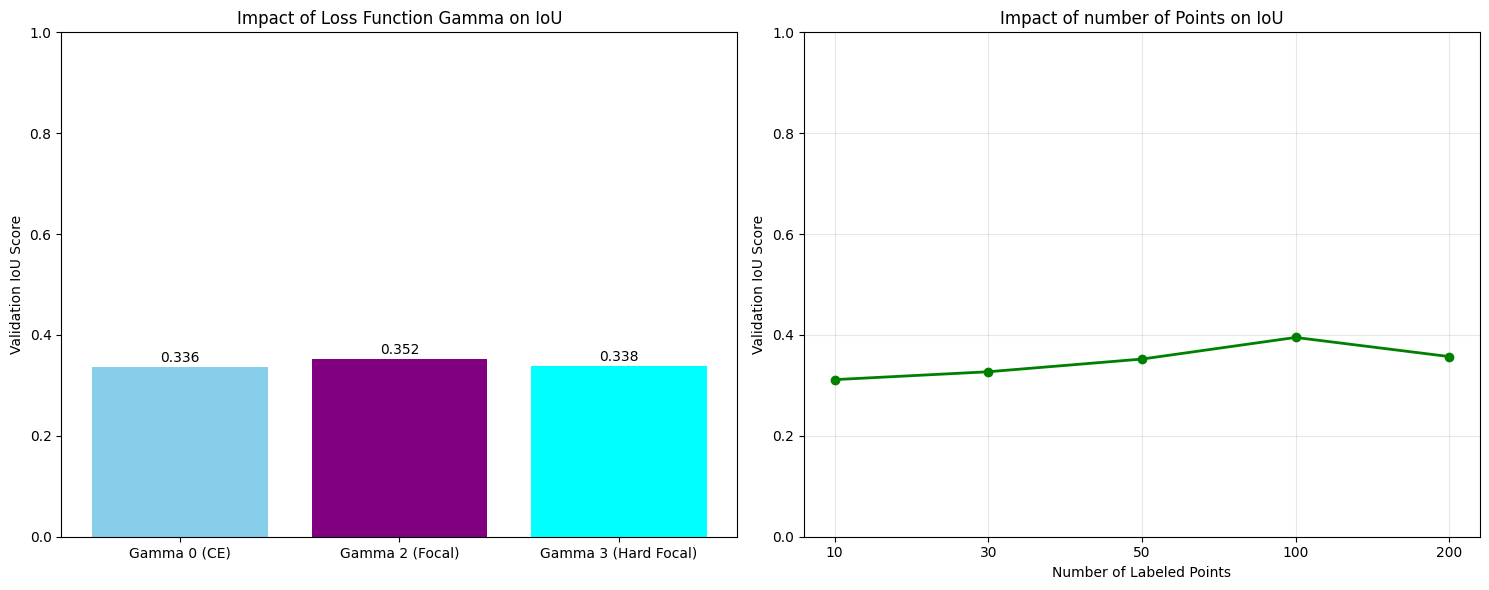

In [10]:
gamma_exp_names = ["exp_gamma0_pts50", "exp_gamma2_pts50", "exp_gamma3_pts50"]
gamma_labels = ["Gamma 0 (CE)", "Gamma 2 (Focal)", "Gamma 3 (Hard Focal)"]
gamma_scores = [last_results_saved[k] for k in gamma_exp_names]

points_exp_names = ["exp_gamma2_pts10", "exp_gamma2_pts30", "exp_gamma2_pts50", "exp_gamma2_pts100", "exp_gamma2_pts200"]
points_labels = ["10", "30", "50", "100", "200"]
points_scores = [last_results_saved[k] for k in points_exp_names]


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Gamma stuff
ax[0].bar(gamma_labels, gamma_scores, color=['skyblue', 'purple', 'cyan'])
ax[0].set_title("Impact of Loss Function Gamma on IoU")
ax[0].set_ylabel("Validation IoU Score")
ax[0].set_ylim(0, 1.0)
for i, v in enumerate(gamma_scores):
    ax[0].text(i, v + 0.01, f"{v:.3f}", ha='center')

# points
ax[1].plot(points_labels, points_scores, marker='o', linestyle='-', color='green', linewidth=2)
ax[1].set_title("Impact of number of Points on IoU")
ax[1].set_xlabel("Number of Labeled Points")
ax[1].set_ylabel("Validation IoU Score")
ax[1].set_ylim(0, 1.0)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
def load_model_weights(path):
    
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights=None, 
        in_channels=3,
        classes=2,
        activation=None
    )
    

    model.load_state_dict(torch.load(path, map_location=CONFIG["DEVICE"]))

        
    model.to(CONFIG["DEVICE"])
    model.eval()
    return model

def visualize0(model_paths, val_loader, num_samples=1):

    images, full_masks, _ = next(iter(val_loader))
    
    for idx in range(num_samples):
        img = images[idx].to(CONFIG["DEVICE"])
        mask = full_masks[idx].cpu().numpy()
        
        num_models = len(model_paths)
        fig, axes = plt.subplots(1, 2 + num_models, figsize=(5 * (2 + num_models), 5))
        
        # actual image
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        axes[0].imshow(img_np)
        axes[0].set_title("Input Image")
        axes[0].axis('off')
        
        # the ground truth
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
        
        # predictions 
        for i, (name, path) in enumerate(model_paths.items()):
            model = load_model_weights(path)
            if model is None: continue
            
            with torch.no_grad():
                logits = model(img.unsqueeze(0))
                pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
            
            ax_idx = i + 2
            axes[ax_idx].imshow(pred, cmap='gray')
            axes[ax_idx].set_title(f"Pred: {name}")
            axes[ax_idx].axis('off')
            
            del model
            torch.cuda.empty_cache()
            
        plt.tight_layout()
        plt.show()

## Gamma impact ##


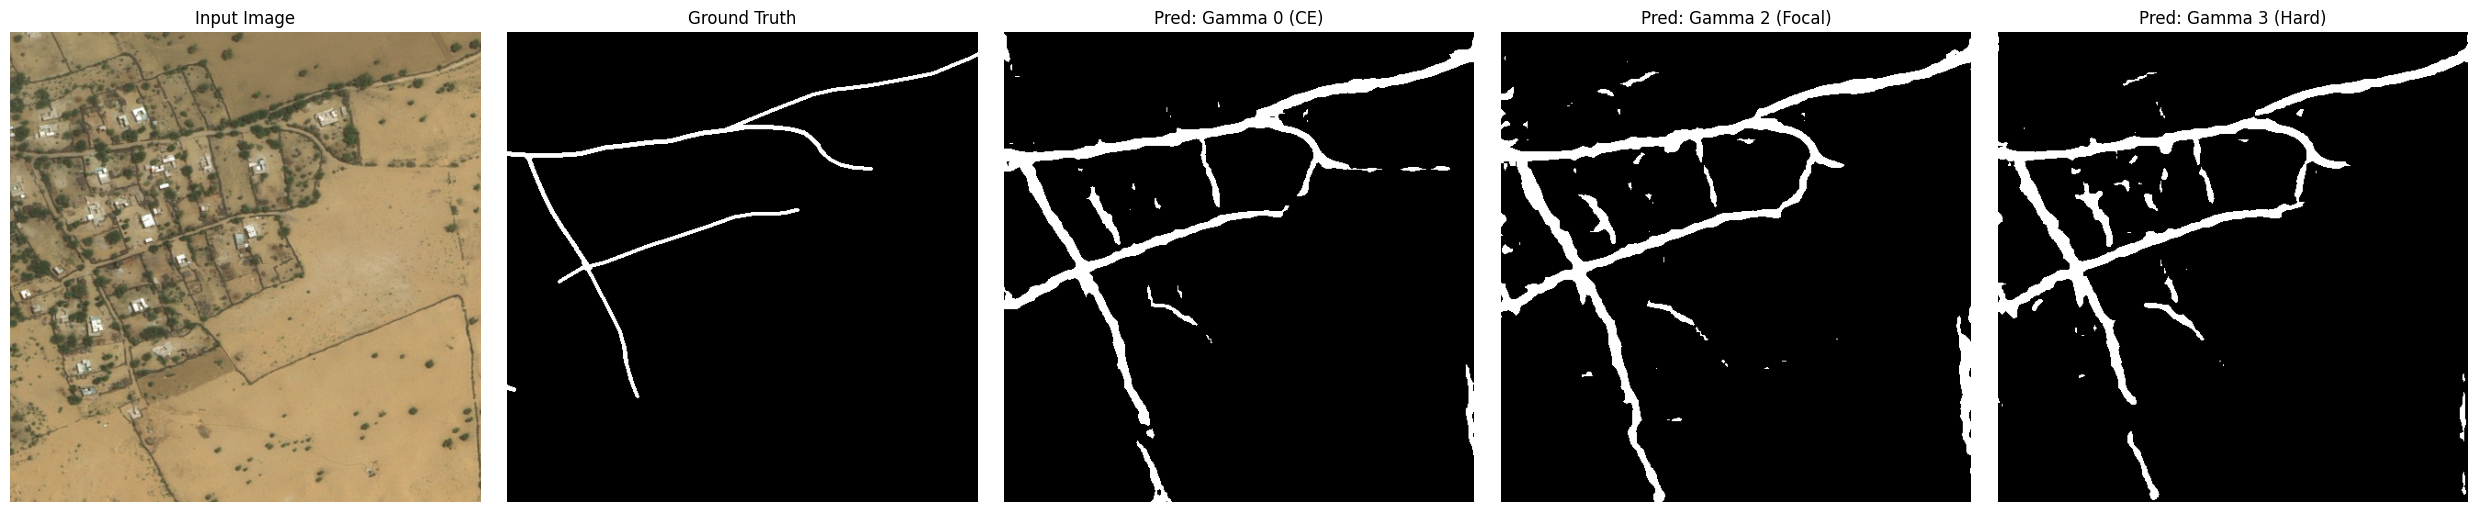

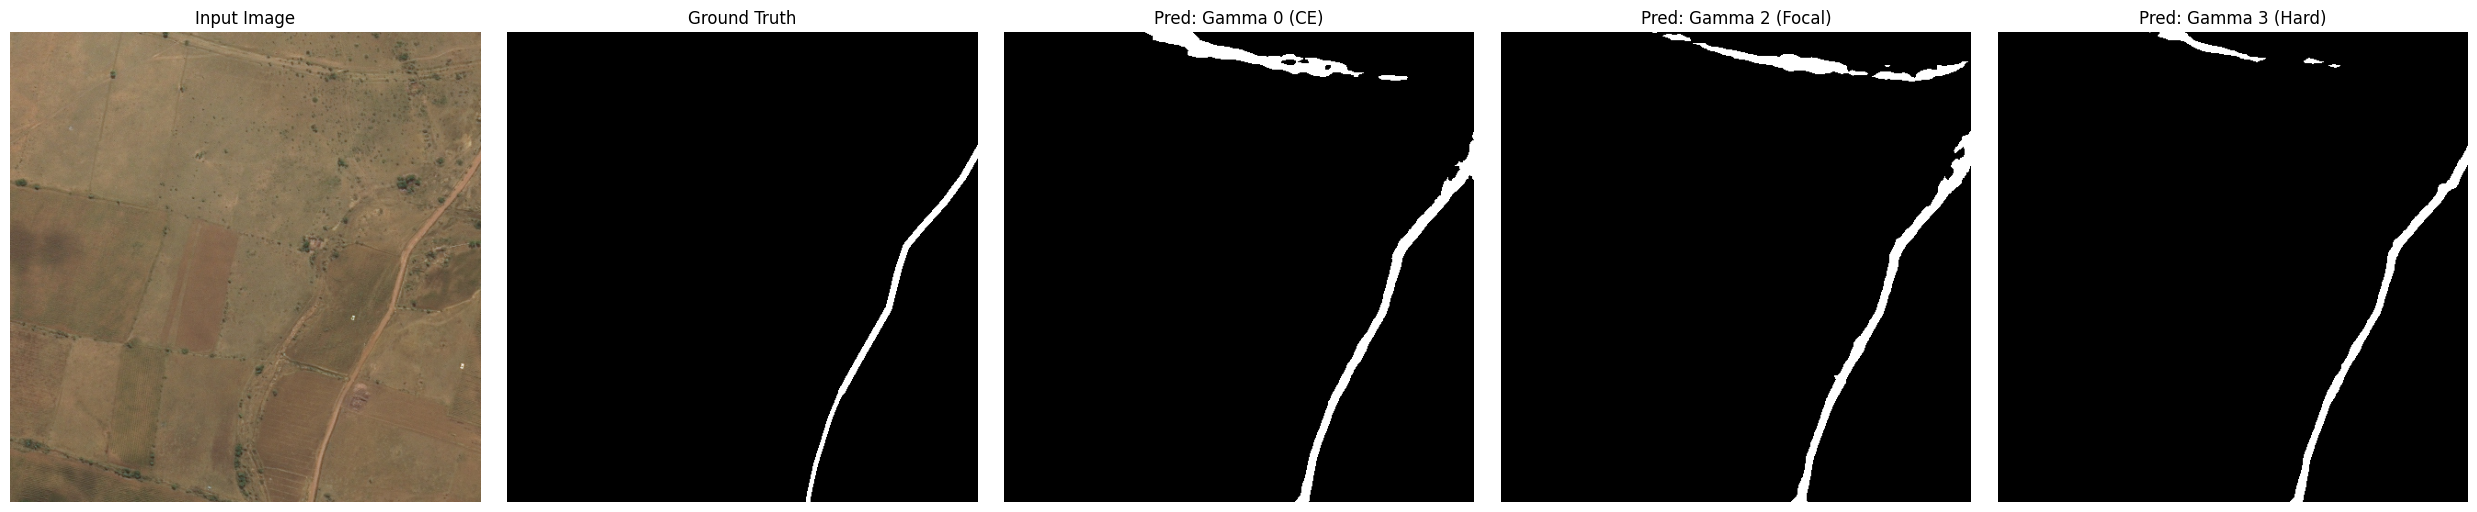

In [12]:
gamma_comparison = {
    "Gamma 0 (CE)": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma0_pts50.pth",
    "Gamma 2 (Focal)": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts50.pth",
    "Gamma 3 (Hard)": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma3_pts50.pth"
}

print("## Gamma impact ##")

visualize0(gamma_comparison, val_loader, num_samples=2)

## Number of points impact ##


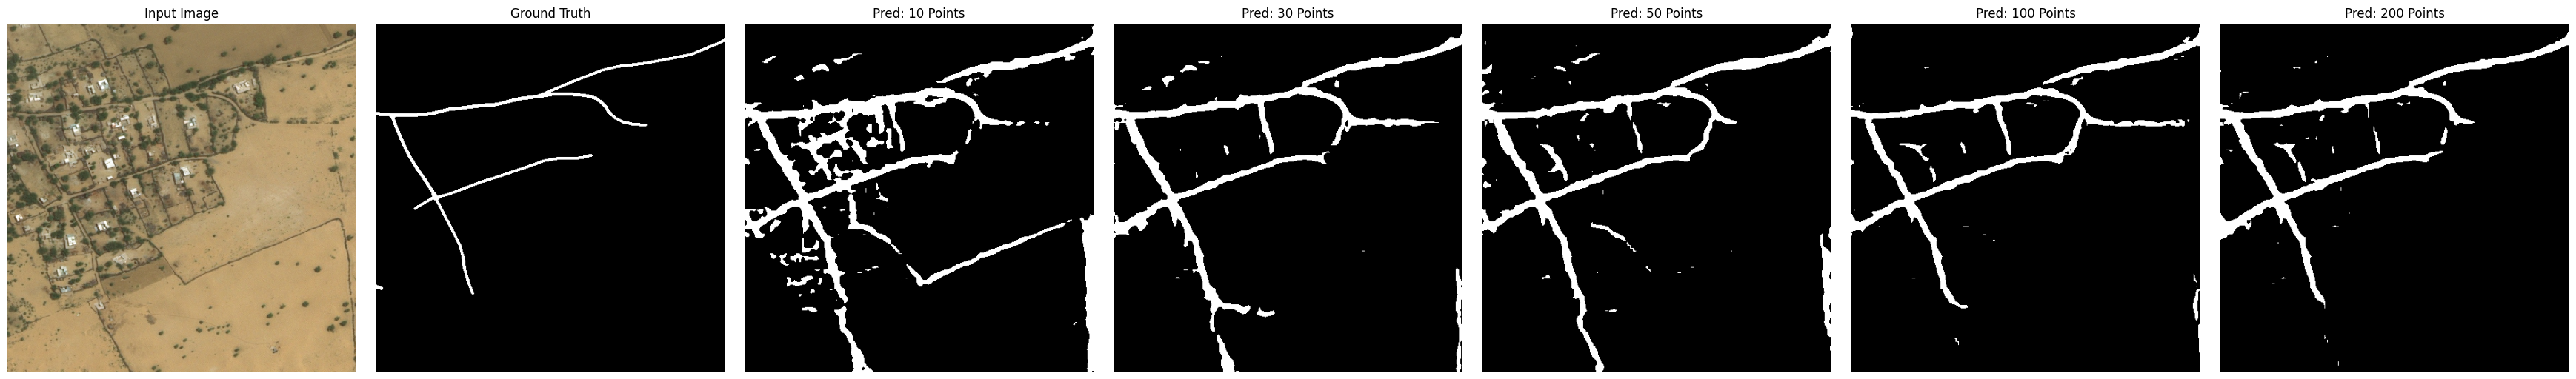

In [13]:
points_comparison = {
    "10 Points": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts10.pth",
    "30 Points": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts30.pth",
    "50 Points": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts50.pth",
    "100 Points": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts100.pth",
    "200 Points": "/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts200.pth"
}

print("## Number of points impact ##")
visualize0(points_comparison, val_loader, num_samples=1)

In [14]:
# cool visuals

def visualize1(model_path, val_loader, sample_index=3, target_num_points=None):

    model = load_model_weights(model_path)
    if model is None: return

    images, full_masks, sparse_masks = next(iter(val_loader))
    
    if sample_index >= len(images):
        sample_index = 0

    images = images.to(CONFIG["DEVICE"])

    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    img_tensor = images[sample_index].cpu()
    img = img_tensor.permute(1, 2, 0).numpy()
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

    full_mask_np = full_masks[sample_index].cpu().numpy()
    pred_np = preds[sample_index].cpu().numpy()

    if target_num_points is not None:

        sparse_mask_np = simulate_points(full_mask_np, num_points=target_num_points, ignore_index=CONFIG['IGNORE_INDEX'])
        print(f"-> Regenerated mask with {target_num_points} points for visualization.")
    else:
        sparse_mask_np = sparse_masks[sample_index].cpu().numpy()

    ys, xs = np.where(sparse_mask_np != CONFIG['IGNORE_INDEX'])
    print(f"Visualizing {model_path}: found {len(xs)} labeled points to circle.")

    plot_list = [
        (img,            "Input Image",      None,      False),
        (sparse_mask_np, f"Sparse ({len(xs)} pts)", "viridis", False),
        (pred_np,        "Prediction",       "gray",    False),
        (full_mask_np,   "Ground Truth",     "gray",    False),
        (img,            "Input + Overlay",  None,      True),
        (sparse_mask_np, "Sparse + Overlay", "viridis", True)
    ]

    num_plots = len(plot_list)
    cols = min(4, num_plots)
    rows = math.ceil(num_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    if rows > 1: axes = axes.flatten()
    else: axes = [axes]

    for i, (data, title, cmap, overlay) in enumerate(plot_list):
        ax = axes[i]
        vmin, vmax = (0, 255) if cmap == 'viridis' else (0, 1)
        ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')

        if overlay:
            ax.scatter(xs, ys, s=50, facecolors='none', edgecolors='red', linewidth=1.5)

    for j in range(i + 1, len(axes)): axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
    del model
    torch.cuda.empty_cache()

-> Regenerated mask with 100 points for visualization.
Visualizing /kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts100.pth: found 100 labeled points to circle.


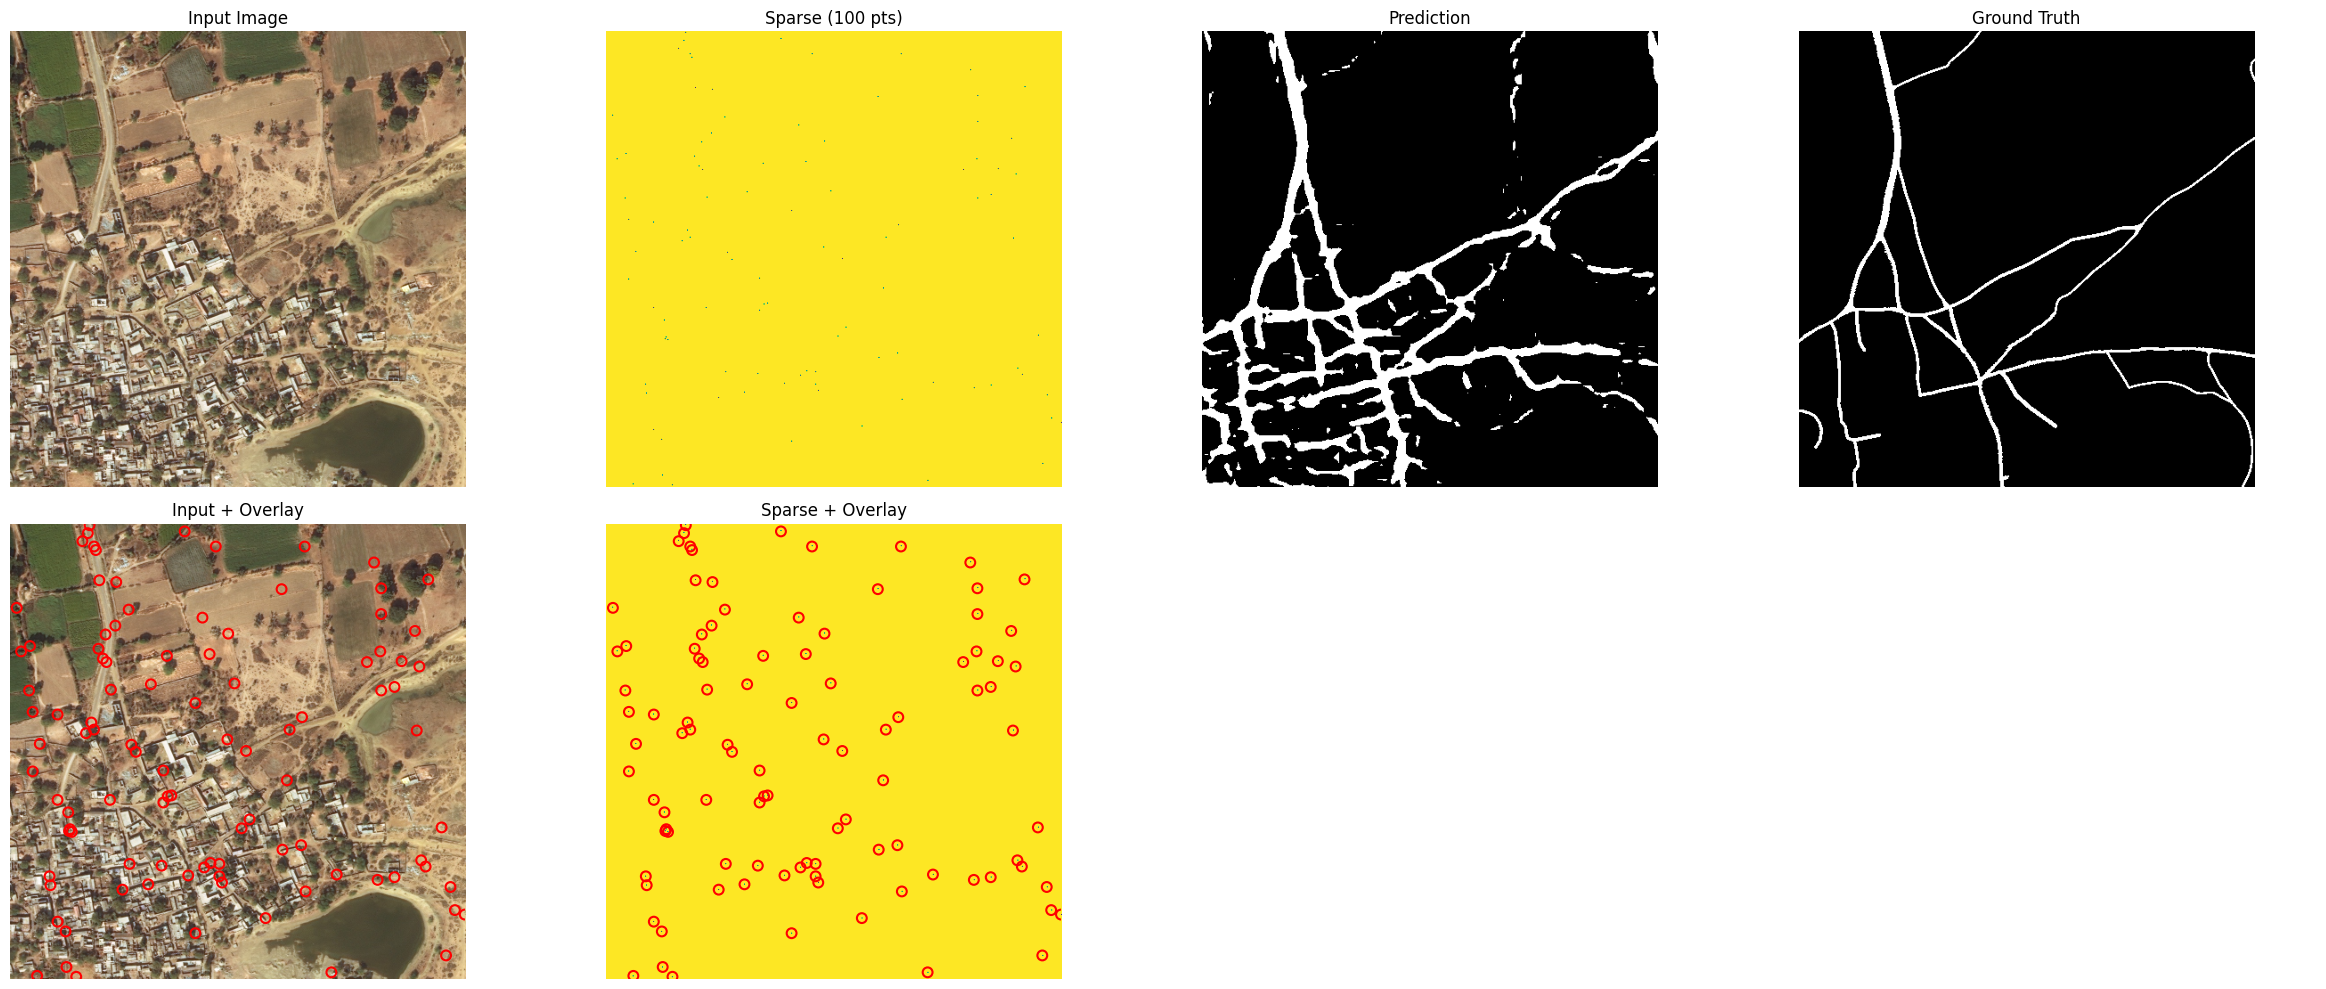

In [15]:
visualize1("/kaggle/input/weekly-supervision/pytorch/default/1/exp_gamma2_pts100.pth", val_loader, sample_index=3, target_num_points=100)